# Entrenamiento: Autoencoder

Notebook para el entrenamiento del modelo "Cloud Top Height", cuyo trabajo es determinar la altura de las nubes en cada pixel.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [2]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [3]:
trainconfig.preparar_dataset_GAN()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [11]:
lista_keys_X = ["CTH","COD","CM"]
lista_keys_y = ["CTH","COD","CM"]

def callback_x(inputs):
    return (inputs*2 - 1) 

def callback_y(inputs):
    return (inputs*2 - 1) 
    
secuenciador = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_GAN,
    callback_x = callback_x,
    callback_y = callback_y,
)

### Importamos modelo

In [46]:
modelo = modelos.Modelo_Autoencoder(
    num_inputs = trainconfig.GAN_NOISE_DIM,
    path_pesos_decoder = f"{trainconfig.DIR_PESOS}/GAN_gen/pesos.tf"
)
modelo.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 37, 37, 3)]       0         
                                                                 
 modelo__encoder_6 (Modelo_E  (None, 50)               64530     
 ncoder)                                                         
                                                                 
 modelo_gan_generador_6 (Mod  (None, 37, 37, 3)        407193    
 elo_GAN_generador)                                              
                                                                 
Total params: 471,723
Trainable params: 64,306
Non-trainable params: 407,417
_________________________________________________________________


### Entrenamos modelo

In [ ]:
epochs = 50
learning_rate = 0.0001

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

try:
    history = modelo.fit(
        secuenciador,
        epochs=epochs,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento Autoencoder",weight="bold")
plt.plot(history.history["loss"],label="loss")
plt.xlabel("Epoca")
plt.ylabel("loss")
plt.grid()
plt.legend()

Epoch 1/50
379/379 [==============================] - 191s 503ms/step - loss: 0.2793
Epoch 2/50
379/379 [==============================] - 197s 519ms/step - loss: 0.2155
Epoch 3/50
379/379 [==============================] - 199s 524ms/step - loss: 0.1965
Epoch 4/50
379/379 [==============================] - 199s 526ms/step - loss: 0.1852
Epoch 5/50
379/379 [==============================] - 201s 531ms/step - loss: 0.1782
Epoch 6/50
379/379 [==============================] - 200s 528ms/step - loss: 0.1736
Epoch 7/50
379/379 [==============================] - 202s 532ms/step - loss: 0.1702
Epoch 8/50
379/379 [==============================] - 200s 527ms/step - loss: 0.1676
Epoch 9/50
379/379 [==============================] - 199s 526ms/step - loss: 0.1653
Epoch 10/50
379/379 [==============================] - 199s 526ms/step - loss: 0.1635
Epoch 11/50
379/379 [==============================] - 199s 526ms/step - loss: 0.1617
Epoch 12/50
379/379 [==============================] - 200s 527

### Guardamos pesos

In [7]:
modelo.save_weights(f"{trainconfig.DIR_PESOS}/CTH/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/CTH/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//CTH/pesos.tf


## Inspección visual resultados

Text(0.5, 1.0, 'y inferencia')

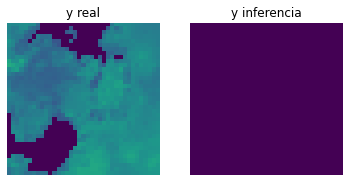

In [44]:
batch = 0
index = 17

x_prueba , y_real = secuenciador.__getitem__(batch)

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]

fig,ax = plt.subplots(1,2)
for i in range(2): ax[i].axis("off")

ax[0].imshow(y_real,vmin=-1,vmax=1,cmap="viridis")
ax[0].set_title("y real")
im = ax[1].imshow(y_inferencia[:,:,0],vmin=-1,vmax=1,cmap="viridis")
ax[1].set_title("y inferencia")

(array([1952.,   37.,    8.,    5.,    2.,  118.,  796.,  136.,    2.,
        1051.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

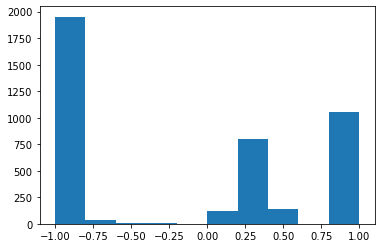

In [27]:
plt.hist(y_inferencia.reshape(-1))